# Clustering Credit Card Users

# Introduction

In Machine Learning, Clustering techniques are those which try to establish meaningful groupings of data points. 

In this analysis, we implement some of these techniques on a publically available dataset, https://www.kaggle.com/datasets/arjunbhasin2013/ccdata

This dataset is not well documented, but will serve our purposes well after we clean it up, and remove the data included that we have no information to contextualise. 

## Import the important libraries for our analysis

In [26]:
# Libraries for mathematical operations and data plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pydotplus import graph_from_dot_data
import matplotlib.style as style

# Libraries to implement our algorithms
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedians import kmedians
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Libraries that provide metrics to evaluate algorithm performance
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, normalize
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz

## Preliminary Data Analysis and Visualisation

In [3]:
#Read the dataset into the notebook and look at the first few rows
original_df = pd.read_csv('credit.csv')
original_df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


First, we make a copy of the dataset to work with in this notebook, but maintain a copy of the original dataset for comparison. This is not viable with massive datasets, but is fine here.

Let's separate off the Customer ID's as they won't be of any use in clustering, and remove a couple of columns that are poorly documented/

In [4]:
df = original_df
df.drop(['CUST_ID'],axis=1,inplace=True)
df.drop(['BALANCE_FREQUENCY'],axis=1,inplace=True)
df.drop(['PRC_FULL_PAYMENT'],axis=1,inplace=True)

Now let's have a look at a summary of each column to understand them a little further

In [5]:
df.describe()

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000
mean,1564.474828,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,11.517318
std,2081.531879,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,6.000000
25%,128.281915,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,12.000000
50%,873.385231,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,12.000000
75%,2054.140036,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,12.000000
max,19043.138560,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,12.000000


Some of the columns have been scaled to be between 0 and 1 already.

In clustering, scaling is an important part of data pre-processing. It ensures that each attribute of your data will be weighted equally by the clustering algorithms.

The following is a summary of the data contained in this dataset:

- BALANCE : Current remaining balance amount left in their account
- PURCHASES : ONEOFF_PURCHASES + INSTALLMENTS_PURCHASES 
- ONEOFF_PURCHASES : Total sum of purchase done as 'one-off' purchases 
- INSTALLMENTS_PURCHASES : Total sum of purchase done in installments
- CASH_ADVANCE : Cash given by the user in the form of cash withdrawals 
- PURCHASES_FREQUENCY : ONEOFFPURCHASESFREQUENCY + PURCHASESINSTALLMENTSFREQUENCY 
- ONEOFFPURCHASESFREQUENCY : How frequently one off Purchases are made (SCALED 0 to 1)
- PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (SCALED 0 to 1)
- CASHADVANCEFREQUENCY : How frequently the cash in advance being paid (SCALED 0 to 1)
- CASHADVANCETRX : Number of cash withdrawals in their tenure
- PURCHASES_TRX : Numbe of purchase transactions made 
- CREDIT_LIMIT : Limit of Credit Card for user
- PAYMENTS : Total payment made by the user in the last 12 months (or less for Tenure < 12)
- MINIMUM_PAYMENTS : Minimum total payment required of the user to not be fined in the last 12 months (or less for Tenure < 12)
- TENURE : Tenure of credit card service for user 

Now we check for missing data entries:

In [6]:
df.isna().sum()

BALANCE                               0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
TENURE                                0
dtype: int64

MINIMUM_PAYMENTS has lots of missing values, so one candidate solution is to remove the column entirely. With only 3% of missing data, this is an overstep, as removing the column entirely is removing plenty of useful data, as it informs us which users are behind on their bills. We will remove the rows with this missing data, rahter than the entire column.

CREDIT_LIMIT has only one missing value, so it's best to just replace it with the column median. 

In [7]:
df = df[df.MINIMUM_PAYMENTS.isna() == False] #remove the rows that have null value in the Minimum Payments columns
df.loc[df.CREDIT_LIMIT.isna(), 'CREDIT_LIMIT'] = df.CREDIT_LIMIT.median() #fill the remaining missing point with it's column mean

Upon closer inspection of the dataset, Minimum Payments often exceed Payments. 

In [8]:
sum(df.MINIMUM_PAYMENTS > df.PAYMENTS)

2365

This means that 2365 of the 8950 customers are behind on their bills, and paying fines for it. 


<Axes: xlabel='PURCHASES', ylabel='Count'>

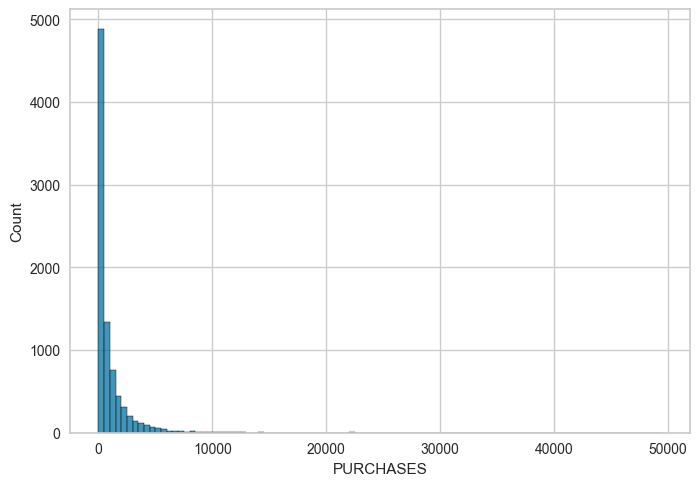

In [9]:
sns.histplot(data=df, x="PURCHASES", binwidth=500)

This histogram shows in the first bar on the left that the majority of the user's have spent less than $500 over the recorded period. There are some outliers, but the overwhelming majority have spent less than $10,000. 

For our algorithms to work more effectively, we need to scale and normalize the data entirely. 

In [10]:
scaler = StandardScaler() ##create scaler object
scaled_df = scaler.fit_transform(df) ##use scaler object to scale our data
normalized_df = normalize(scaled_df)  ##normalise our data (returns a numpy array)
normalized_df = pd.DataFrame(normalized_df)  ## turn our normalised numpy array back into a dataframeb

In [11]:
normalized_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.324140,-0.186828,-0.156349,-0.154456,-0.204019,-0.357246,-0.298744,-0.312178,-0.296910,-0.208715,-0.225324,-0.419053,-0.236781,-0.132991,0.154689
1,0.216105,-0.133797,-0.101551,-0.129734,0.726344,-0.349485,-0.194039,-0.261959,0.157510,0.028079,-0.168812,0.191512,0.225349,0.024808,0.100473
2,0.124506,-0.033953,0.029166,-0.133874,-0.136742,0.366538,0.772307,-0.270319,-0.199002,-0.139890,-0.035132,0.237498,-0.116554,-0.029141,0.103679
3,-0.164565,-0.205047,-0.153914,-0.201972,-0.206299,-0.452662,-0.179813,-0.407822,-0.300228,-0.211048,-0.245326,-0.399674,-0.167328,-0.114940,0.156418
4,0.048596,0.069315,-0.175154,0.485227,-0.228557,0.207505,-0.334675,0.262871,-0.332620,-0.233818,-0.136202,-0.362818,-0.064404,0.317223,0.173294


It is worth noting here that I am choosing not to remove any outliers - those outliers could well be the exact customers we are hoping to capture by doing this clustering. 

K-means is known to be sensitive to outliers, and so it might be useful to compare its results to a more robust form of clustering such as K-mediods, or K-Medians

### K Means Clustering

We first attempt to uncover clusters in the data using K-Means - K Means makes the assumption that the clusters will be normally spread around cluster centers, in whatever number of dimensions the data exists in, which is not a promising assumption for this data. We can see the the data is more exponential in form than normal from the plots above. Still, it is a common first algorithm to try, and we do so here.

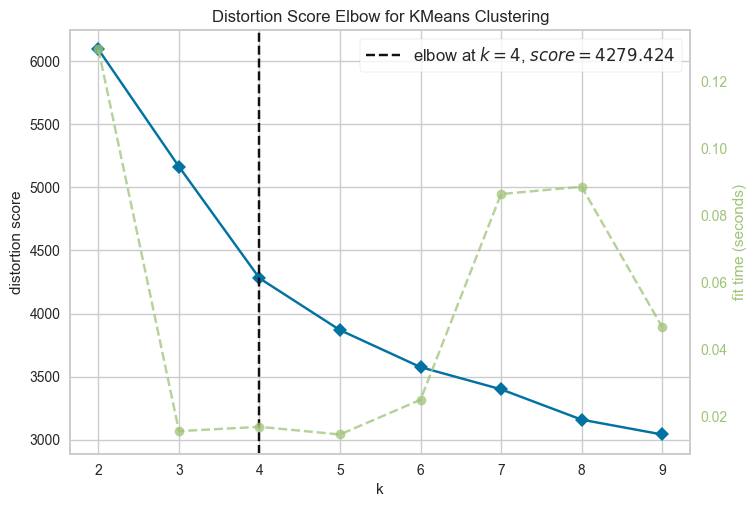

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(2,10))  # Tool to see how the algorithm fit changes as the parameter changes 
visualizer.fit(normalized_df)                   # Fit the data to the visualizer
visualizer.show() 

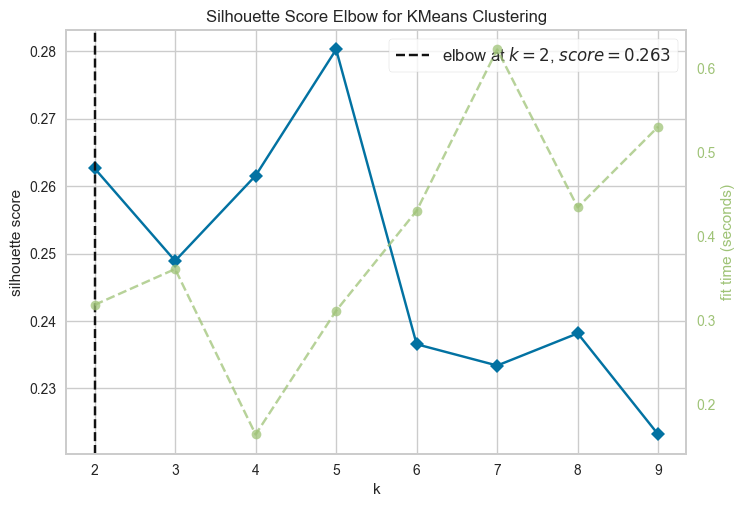

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [21]:
# Instantiate the clustering model and visualizer
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(2,10),metric='silhouette')
visualizer.fit(normalized_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

This preliminary attempt suggests there are 4 or 5 clusters in our data.

#### PCA improvement

PCA is a tool which helps us shrink the number of dimensions the data has, while trying to minismise the amount of data lost. It will help our clustering for the sake of a little bit of lost explained varience.

In [17]:
pca = PCA(n_components=8)
pca_df = pca.fit_transform(normalized_df)
np.cumsum(pca.explained_variance_ratio_)[-1]

0.9102240162523703

In [18]:
pca_df = pd.DataFrame(pca_df) 
pca_df.head()

,0,1,2,3,4,5,6,7
0,-0.494206,-0.678627,-0.081943,0.115710,-0.000016,-0.050605,-0.110618,0.094950
1,-0.516440,0.548469,0.183329,-0.207875,-0.270772,0.188776,0.025402,0.090627
2,0.328590,0.276706,0.121406,0.745058,0.131233,-0.101088,0.053194,-0.404926
3,-0.482199,-0.086533,0.461915,0.282819,-0.390451,-0.265610,-0.044527,-0.027813
4,-0.568003,-0.481474,-0.243832,0.325600,0.029468,0.086972,0.042740,0.139952


So, we have lost 10.3% of the explained varience, for the trade off of having fewer parameters to work with. We can expect it to cluster better now.

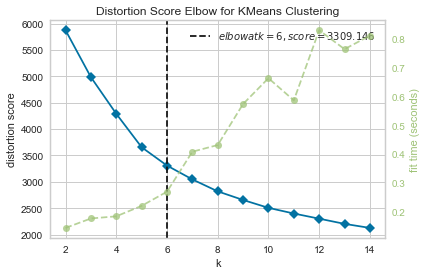

In [19]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15))

visualizer.fit(pca_df)        # Fit the data to the visualizer
visualizer.show()    

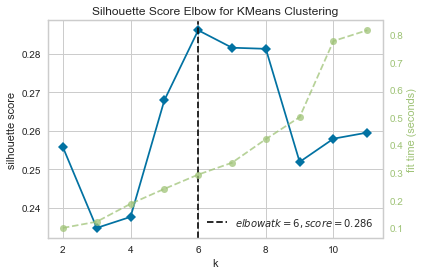

In [20]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12),metric='silhouette')
visualizer.fit(pca_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

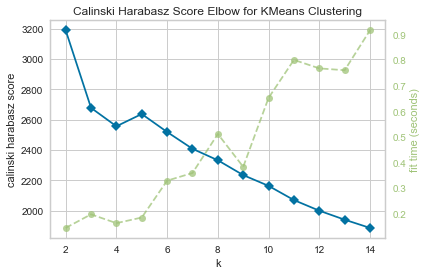

In [21]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15),metric='calinski_harabasz')

visualizer.fit(pca_df) 
visualizer.show() 

The Silhoutte score is slightly higher for 7/8 clusters than it is for 5 clusters, but there is a big drop off in the CH score after 5. 

So it's looking like 5 clusters could be a good way to model the data according to K Means

### Hierarchical Agglomerative Clustering

Let's run HAC and compare the results with K Means looking at CH Score and Silhouette Score. 

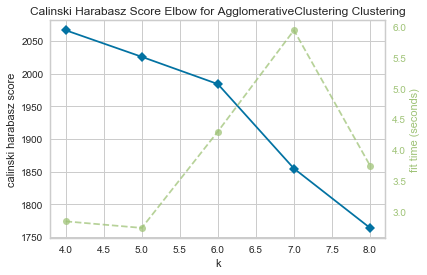

In [22]:
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(4,9), metric='calinski_harabasz')
visualizer.fit(pca_df)
visualizer.show()  

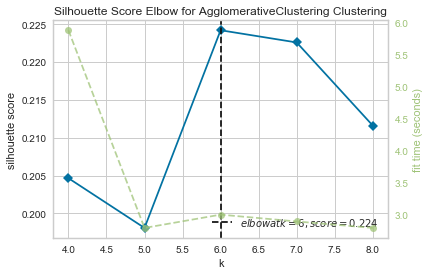

In [23]:
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(4,9), metric='silhouette')
visualizer.fit(pca_df)
visualizer.show()  

With a Silhouetter score at the elbow of 0.179, vs that of K Means at 0.263, we can see that K Means seems to be doing a better job right now! Lets run it on the scaled, normalized df just to be sure.

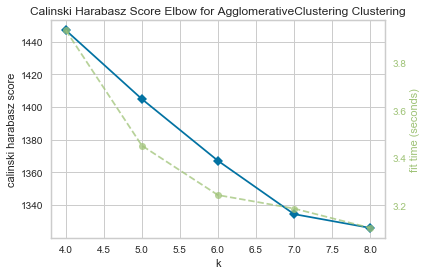

In [24]:
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(4,9), metric='calinski_harabasz')
visualizer.fit(normalized_df)
visualizer.show()

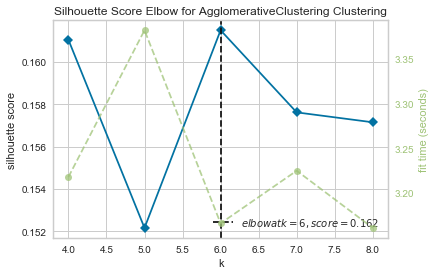

In [25]:
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(4,9), metric='silhouette')
visualizer.fit(normalized_df)
visualizer.show()  

The scores are worse for HAC.

For now, we are going to use the KMeans algorithm with 5 clusters, as it is achieving the best scores!

## Improving and exploring the clusters

1 - We tweak the KMeans algorithm, particularly to mitigate error caused by possible poor initialisation points

2 - We use histograms and Random Forest feature importance to explore what makes each cluster unique 

### Improvements

KMeans has a few parameters that we can tweak under the hood to improve performance.

1 - it is already using k means ++, a better version of picking initial points than just randomly

2 - n_init can be increased, which will rerun the algorithm more times, mitigating error caused by poor 
initialisation points

3 - max_iter - let the algorithm run for longer to try get more accurate clustering

4 - tol - stop the algorithm only at a higher level of convergence 

This will mean longer run time but that is no problem, as we are only running it once now, and the dataset isn't too big

In [26]:
kmean= KMeans(n_clusters=5, init='k-means++', n_init=100, max_iter=500, tol=0.00001)
kmean.fit(pca_df)
labels=kmean.labels_

In [27]:
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,0.000000,12,3
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,0.222222,12,2
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,0.000000,12,0
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,0.000000,12,4
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,0.000000,12,3


### Exploration

Now we have our well defined and labelled clusters, lets have a closer look at them. 

In [28]:
print(clusters.describe())

            BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000

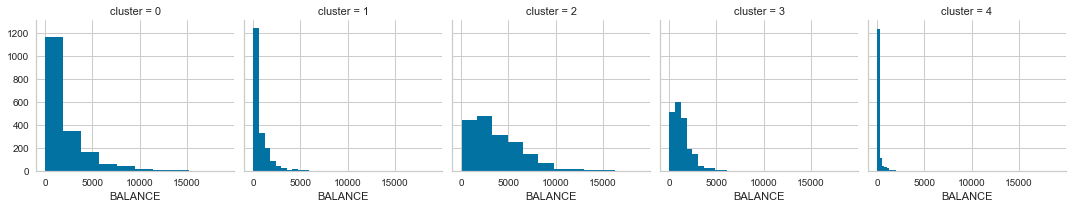

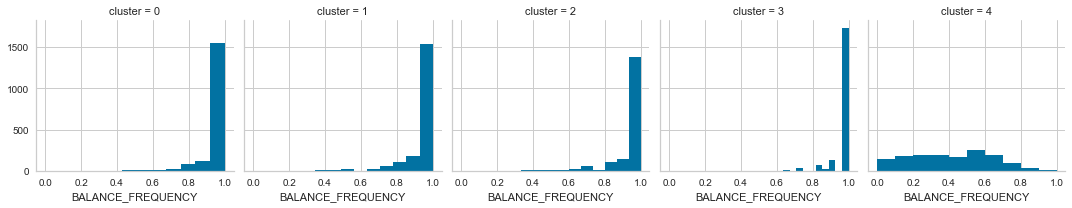

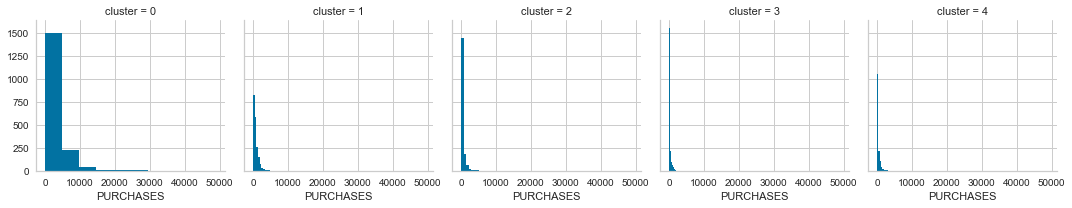

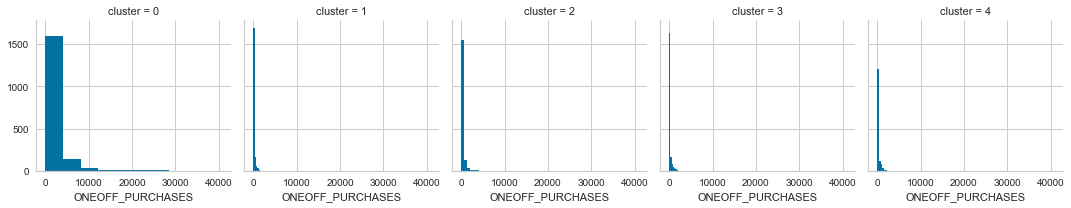

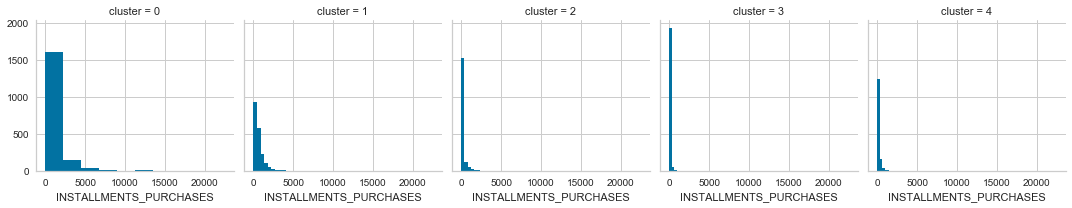

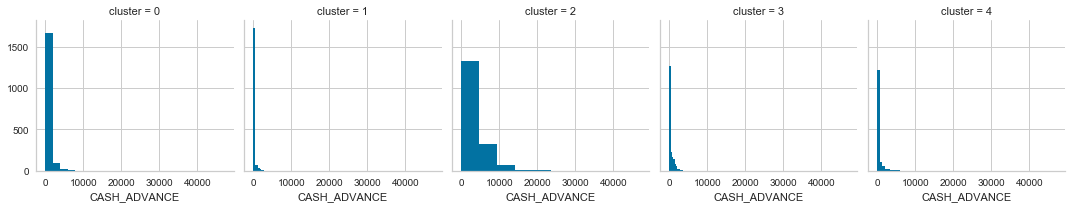

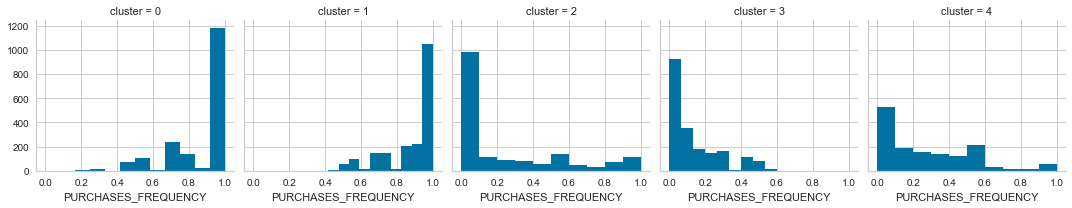

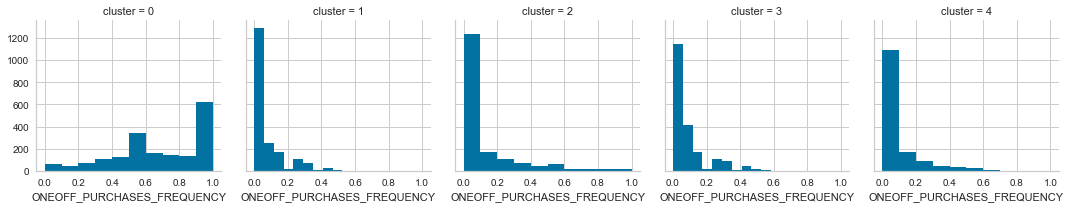

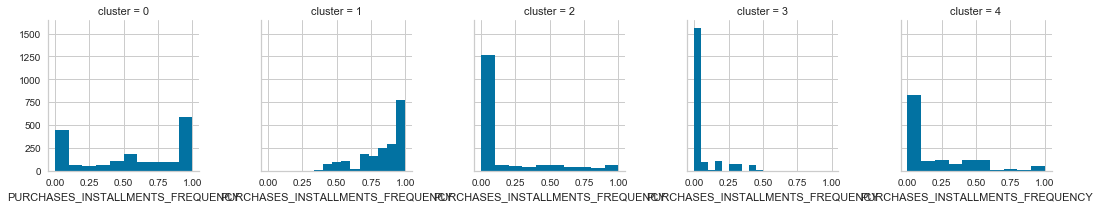

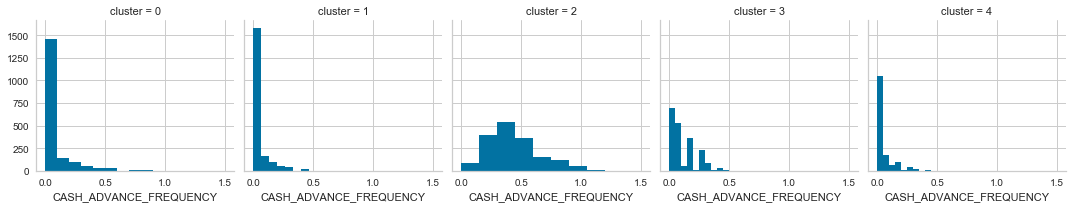

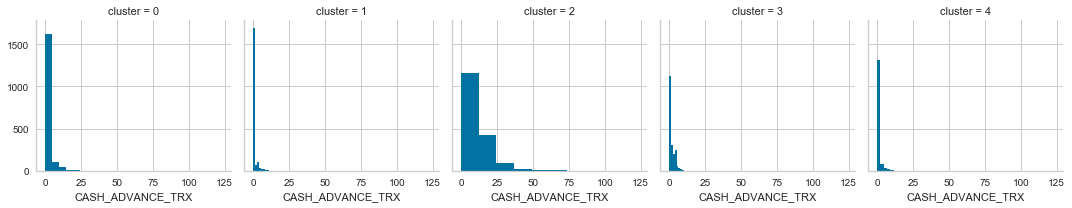

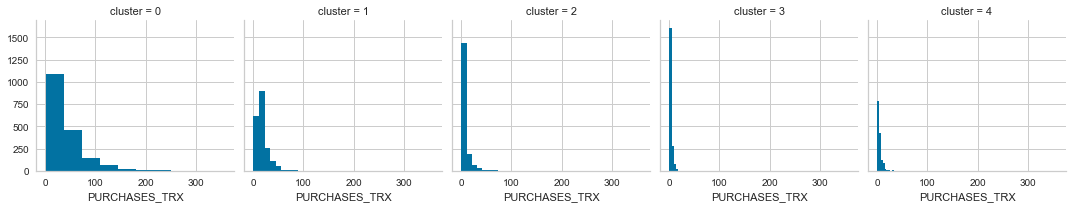

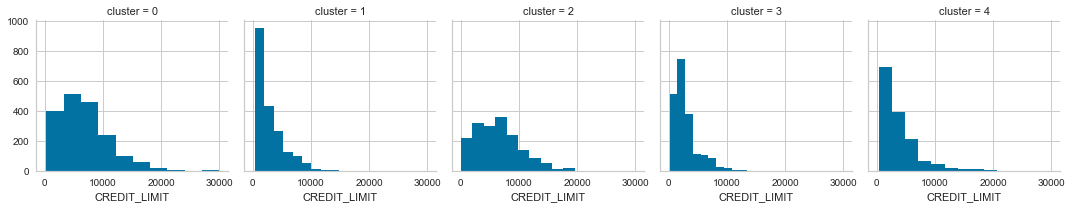

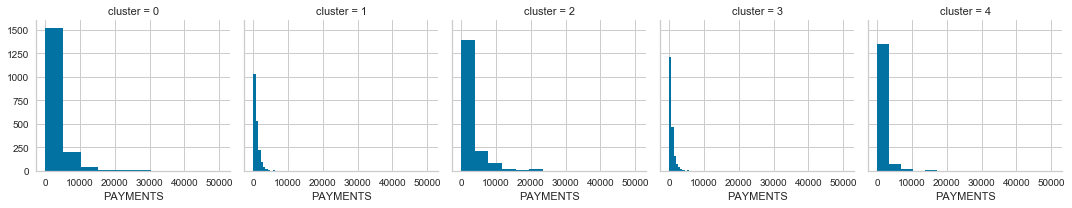

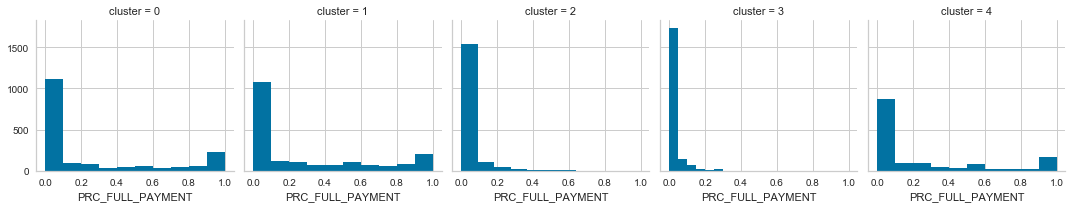

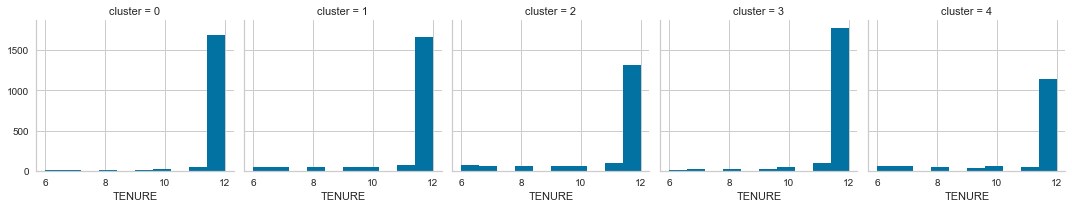

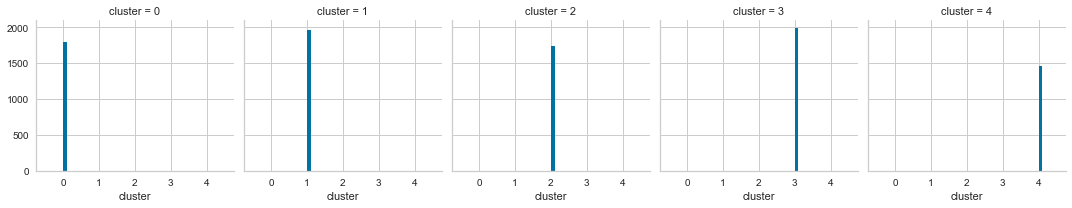

In [29]:
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)
    
# take a look at how the data for each cluster looks as a histogram

Although these histograms are interesting, and clusters look a bit different from each other for some of the categories, we need to have a better look. Histograms have their limits.

Lets use Random Forests' feature importance to get an even better understanding of the clusters

In [30]:
X = clusters.drop(['cluster'],axis=1)
Y = clusters['cluster']
names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [31]:
rf_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

# we limit max depth to 4 because if we have any more depth, our DOT tree below will be completly 
# unreadable, and it is a very useful tool for seeing how are clusters are defined.

In [32]:
rf1 = RandomForestClassifier()

In [33]:
# Instantiate GridSearchCV
rf_grid_search = GridSearchCV(rf1, rf_param_grid, cv=3, return_train_score=True)

# Fit to the data
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

So, what we have done is run the Random Forest algorithm for all values in our parameter grid that we supplied. Now we can ask it which parameters helped it work best!

In [34]:
# Mean training score
rf_gs_training_score = np.mean(rf_grid_search.cv_results_['mean_train_score'])

# Mean test score
rf_gs_testing_score = rf_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {rf_gs_training_score :.2%}")
print(f"Mean Test Score: {rf_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
rf_grid_search.best_params_

Mean Training Score: 85.68%
Mean Test Score: 88.68%
Best Parameter Combination Found During Grid Search:


{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 10}

In [35]:
rf = RandomForestClassifier(criterion='gini',max_depth= 4,min_samples_leaf= 4,min_samples_split= 10, random_state=123)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [36]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.2309, 'PURCHASES_FREQUENCY'), (0.1227, 'ONEOFF_PURCHASES_FREQUENCY'), (0.1093, 'BALANCE_FREQUENCY'), (0.0941, 'CASH_ADVANCE_TRX'), (0.0877, 'BALANCE'), (0.0748, 'CASH_ADVANCE_FREQUENCY'), (0.063, 'ONEOFF_PURCHASES'), (0.0511, 'CASH_ADVANCE'), (0.0448, 'PURCHASES_TRX'), (0.0312, 'PURCHASES_INSTALLMENTS_FREQUENCY'), (0.0268, 'INSTALLMENTS_PURCHASES'), (0.0253, 'PURCHASES'), (0.0218, 'PAYMENTS'), (0.0116, 'CREDIT_LIMIT'), (0.0049, 'PRC_FULL_PAYMENT'), (0.0, 'TENURE')]


We need to have a closer looks at the first few of these features! They are the most important in differentiating between clusters. 

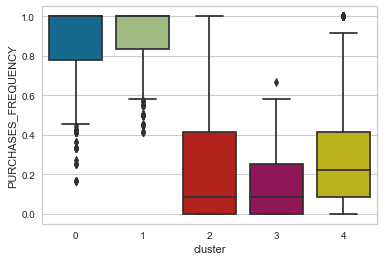

In [37]:
ax = sns.boxplot(x="cluster", y="PURCHASES_FREQUENCY", data=clusters)

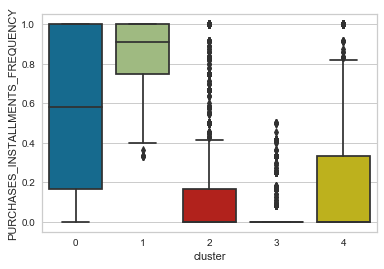

In [38]:
ax = sns.boxplot(x="cluster", y="PURCHASES_INSTALLMENTS_FREQUENCY", data=clusters)

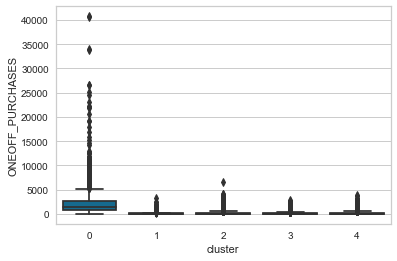

In [39]:
ax = sns.boxplot(x="cluster", y='ONEOFF_PURCHASES', data=clusters)

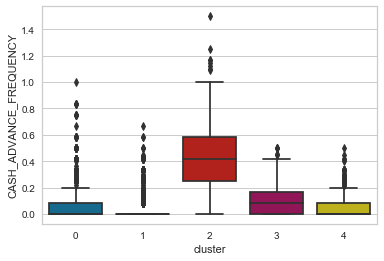

In [40]:
ax = sns.boxplot(x="cluster", y="CASH_ADVANCE_FREQUENCY", data=clusters)

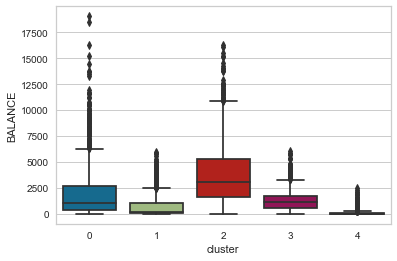

In [41]:
ax = sns.boxplot(x="cluster", y="BALANCE", data=clusters)

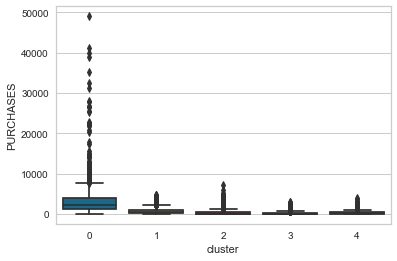

In [42]:
ax = sns.boxplot(x="cluster", y="PURCHASES", data=clusters)

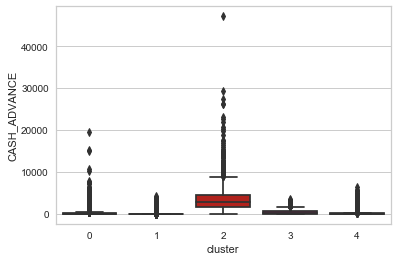

In [43]:
ax = sns.boxplot(x="cluster", y='CASH_ADVANCE', data=clusters)

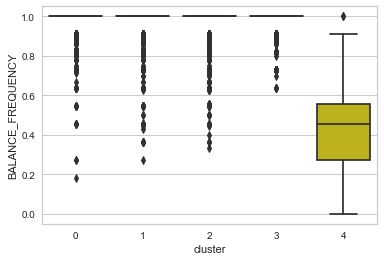

In [44]:
ax = sns.boxplot(x="cluster", y='BALANCE_FREQUENCY', data=clusters)

If we make just one decision tree on these parameters, it'll be interesting to see how it splits the data over it's branches too...

In [45]:
dt = DecisionTreeClassifier(criterion='gini',max_depth= 4,min_samples_leaf= 4,min_samples_split= 10, random_state=123)
dt.fit(X_train, y_train)
# fit the Random Forest classifier with the best criteria

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

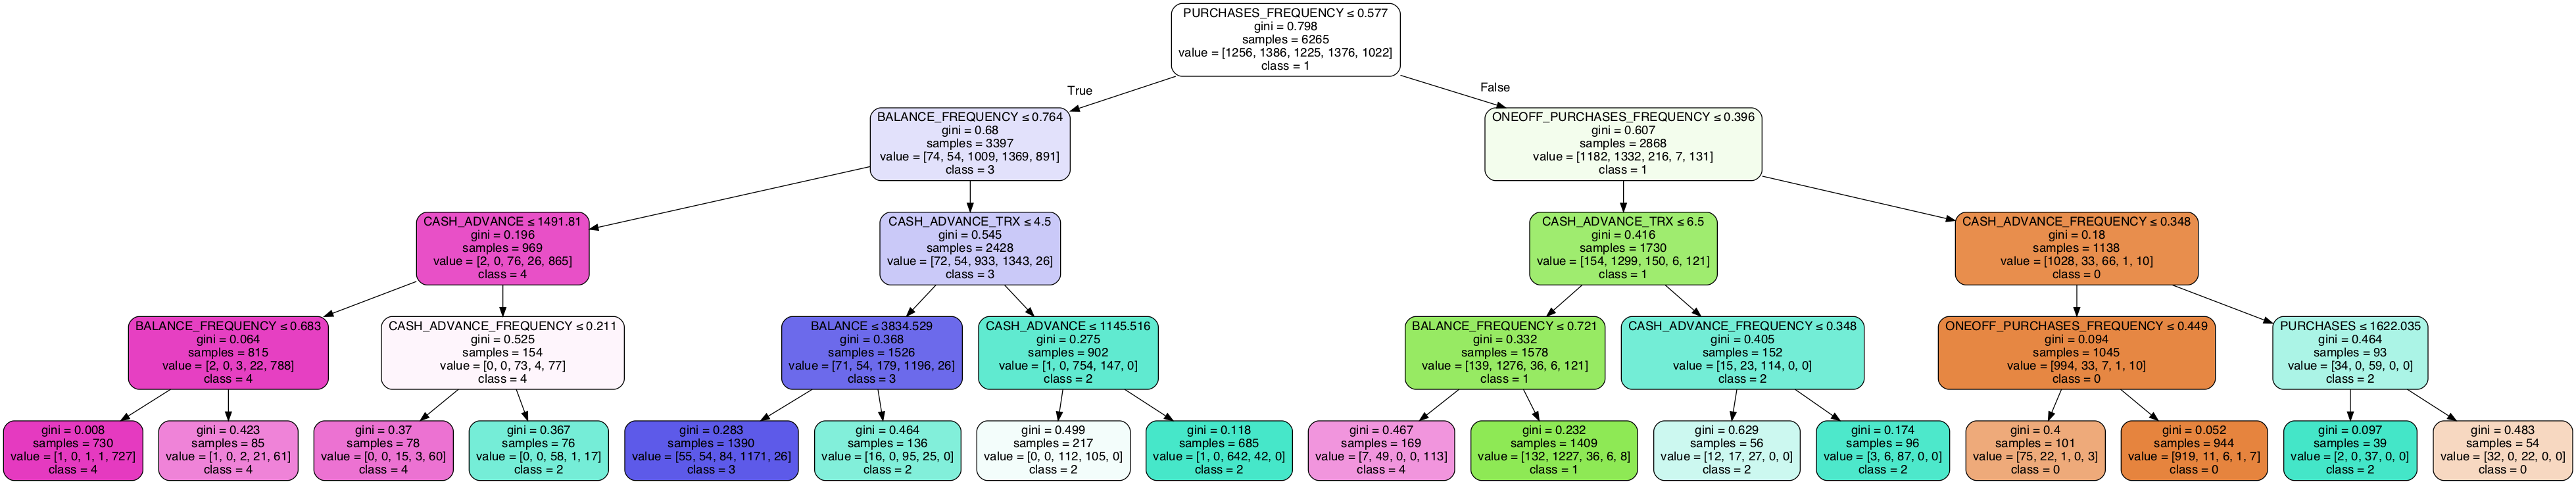

In [46]:
# Create DOT data
dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=names,  
                           class_names=np.unique(Y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
from IPython.display import Image
Image(graph.create_png())

### Cluster Descriptions

So, what are the defining features of each cluster?

0 - Largest Number of Purchases and Largest Sum of Purchases (ie most active users of the card)

1 - Highest Installment Purchases Frequency (ie likely low income/savings, living paycheck to paycheck)

2 - Highest Cash Advance Transactions (ie people who are most careful about their bills/debts. Planners)

3 - Smallest Number of Purchases and Smallest Sum of Purchases (ie least active users of the card)

4 - Very Low Balance Frequency (ie people who are least careful about their bills/debts. Don't plan their purchases)


How accurate was our random forest at labelling the data correctly?

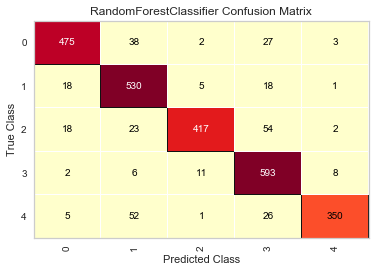

In [47]:
cm = ConfusionMatrix(rf, classes=[0,1,2,3,4])

cm.score(X_test, y_test)

# How did we do?
cm.show()

So, it is worth nothing that cluster 4 is quite often confused for cluster 1! This would be important to note, especially if later down the line we decided to target cluster 4 as it is profitable, but to ignore cluster 1 as it is unprofitable! Same goes for cluster 2 and 3.

## Visualising the clusters

We'll use PCA to take our data down to 2 dimensions - we will lose information like this, but as we are only using this for visualiation, its doesn't matter much

In [48]:
dist = 1 - cosine_similarity(normalized_df) 
pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(8950, 2)

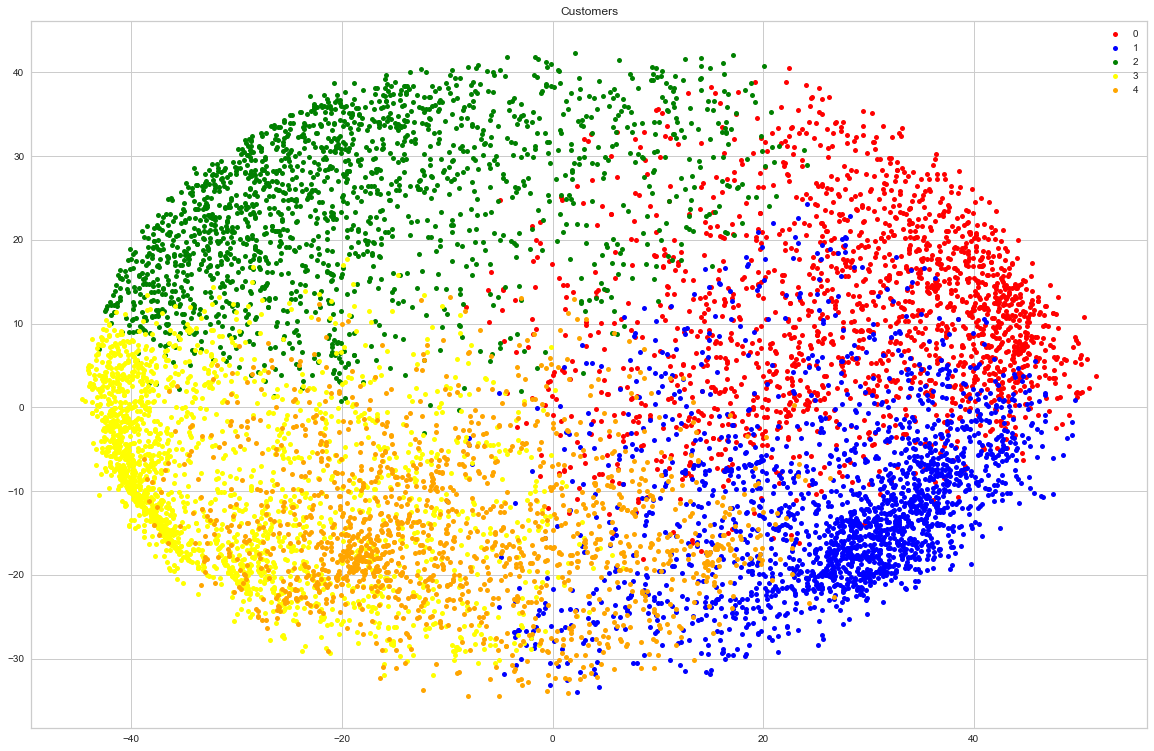

In [50]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5:'purple'}

names = {0: '0', 
         1: '1', 
         2: '2', 
         3: '3', 
         4: '4',
         5:'5'}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers")
plt.show()

# this code is directly taken from Kernel named in references, but I fully understand its use

By our definitions, red (cluster 0) and yellow (cluster 3) should be extremely different, so it is good to see that they are on opposite ends of this graph!

## Business Recommendations

A business goal of all of this could be to recommend advertising to the people who are most likely to belong to the most profitable cluster. Although we don't have the data on these customers in this scenario, in real life we would do. For example, if we decided that cluster 2 is the most profitable, then we could take all the data on those customers that we have (on their demographics) and advertise more specifically to that demographic! 

We could also dissuade bank managers from accepting customers who are likely to be in the least profitable demographic, possibly cluster 3. They are likely to have a lower credit score, be younger etc. but this would have to be explored more with the data the bank's databases would be able to provide. 

# Conclusions and References

Credit to Saba Naseem Butt for her Kernel on visualisations